# Group 5: Machine Learning 2

## Importing Libraries <a class="anchor" id="chapter0"></a>

In [3]:
#!pip install tune_sklearn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn import set_config
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error

pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
pd.options.display.max_columns = 100


## Importing Datasets <a class="anchor" id="chapter0.5"></a>

In [7]:
df = pd.read_csv("train.csv")
test=pd.read_csv('test.csv')


## Data Cleaning <a class="anchor" id="chapter1"></a>

In [8]:
print('Data Dimensions for Train Data:')
print('   Number of Records:', df.shape[0])
print('   Number of Features:', df.shape[1])

Data Dimensions for Train Data:
   Number of Records: 15120
   Number of Features: 56


### Data Types <a class="anchor" id="section_1_1"></a>

In [ ]:
display(df.dtypes)

### Feature Exploration <a class="anchor" id="section_1_2"></a>

In [ ]:
print('Feature Names:')
print(df.columns)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=20, figsize=(20,20))
plt.show()

### Handling Missing Values: No Missing Values <a class="anchor" id="section_1_3">

### Outlier Detection <a class="anchor" id="section_1_4"></a>

In [7]:
def outlier_function(dff, col_name):
    
    first_quartile = np.percentile(np.array(dff[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(dff[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in dff[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count


In [8]:
# loop through all columns to see if there are any outliers
for column in df.columns:
    if outlier_function(df, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df, column)[2], column))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points
There are 3597 outliers in Wilderness_Area1
There are 499 outliers in Wilderness_Area2
There are 355 outliers in Soil_Type1
There are 623 outliers in Soil_Type2
There are 962 outliers in Soil_Type3
There are 843 outliers in Soil_Type4
There are 165 outliers in Soil_Type5
There are 650 outliers in Soil_Type6
There are 1 outliers in Soil_Type8
There are 10 outliers in Soil_Type9
There are 2142 outliers in Soil_Type10
There are 406 outliers in Soil_Type11
There are 227 outliers in Soil_Type12
There are 476 outliers in Soil_Type13
There are 169 outliers in Soil_Type14
There are 114 outliers in Soil_Type16
There are 612 outliers in Soil_Type17
There are 60 outliers in Soil_Type18
There a

here we are going to take a closer look for the outlier elimination for the following columns:

Horizontal_Distance_To_Hydrology
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Horizontal_Distance_To_Fire_Points

We are not considering other columns for potential outlier elimination because their data range is already fixed between 0 and 255 (e.g. Hillsahde columns) or they seem like one-hot-encoded columns (e.g. Soil type and Wilderness areas).

Recalling the data ranges of those 4 columns:

Horizontal_Distance_To_Hydrology: 0, 1343
Vertical_Distance_To_Hydrology: -146, 554
Horizontal_Distance_To_Roadways: 0, 6890
Horizaontal_Distance_To_Firepoints: 0, 6993
    
Considering the Horizaontal_Distance_To_Firepoints having the highest number of outliers and widest data range, I am going to remove outliers only from that column.    

## Checking the Distribution of the Target variables

The training data set that we will use for the model building is evenly distributed across the seven cover types


C:\Users\uSUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


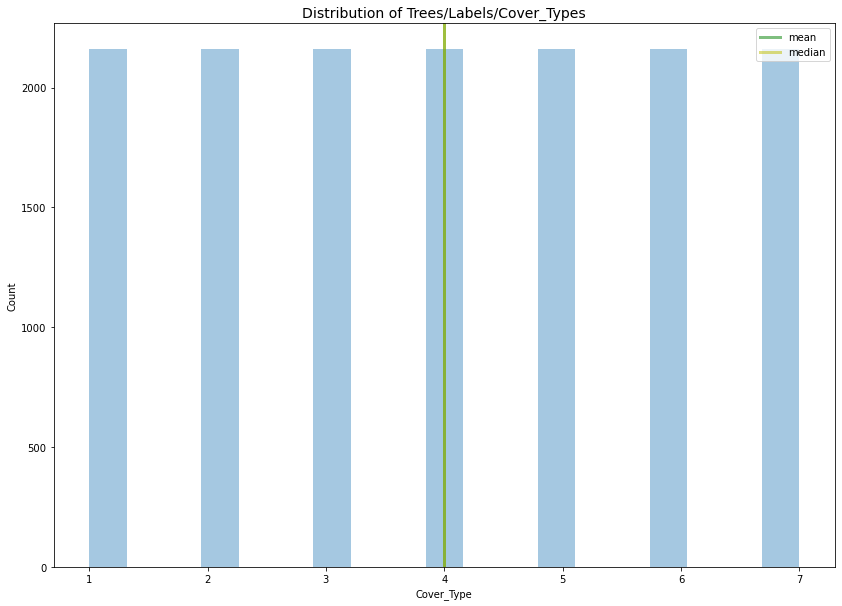

In [9]:
# set the plot size
plt.figure(figsize=(14,10))


# set the histogram, mean and median
sns.distplot(df["Cover_Type"], kde=False)
plt.axvline(df["Cover_Type"].mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(df["Cover_Type"].median(), linewidth=3, color='y', label="median", alpha=0.5)

# set title, legends and labels
plt.xlabel("Cover_Type")
plt.ylabel("Count")
plt.title("Distribution of Trees/Labels/Cover_Types", size=14)
plt.legend(["mean", "median"])

print('The training data set that we will use for the model building is evenly distributed across the seven cover types')

## Findings from Understand, Clean and Format Data

Training dataset has 15120 entries and 56 columns with headers appropriately named. Dataset is clean and well-formatted, meaning it had no NA values and every column has a numeric (float or integer) data type.

4 columns had outliers, outliers of the Horizontal_Distance_To_Fire_Points is removed considering this column has a wider range and has the most number of outliers.

Cover_Type is our label/target column. Wilderness_Area and Soil_Type columns might have binary values (0,1) if so, they are the one-hot-encoded columns of 4 wilderness areas and 40 soil types respectively. I am going to start exploratory data analysis by seeking answer to that suspicion.

## 2. Exploratory Data Analysis


### 2.1 Numerical variables

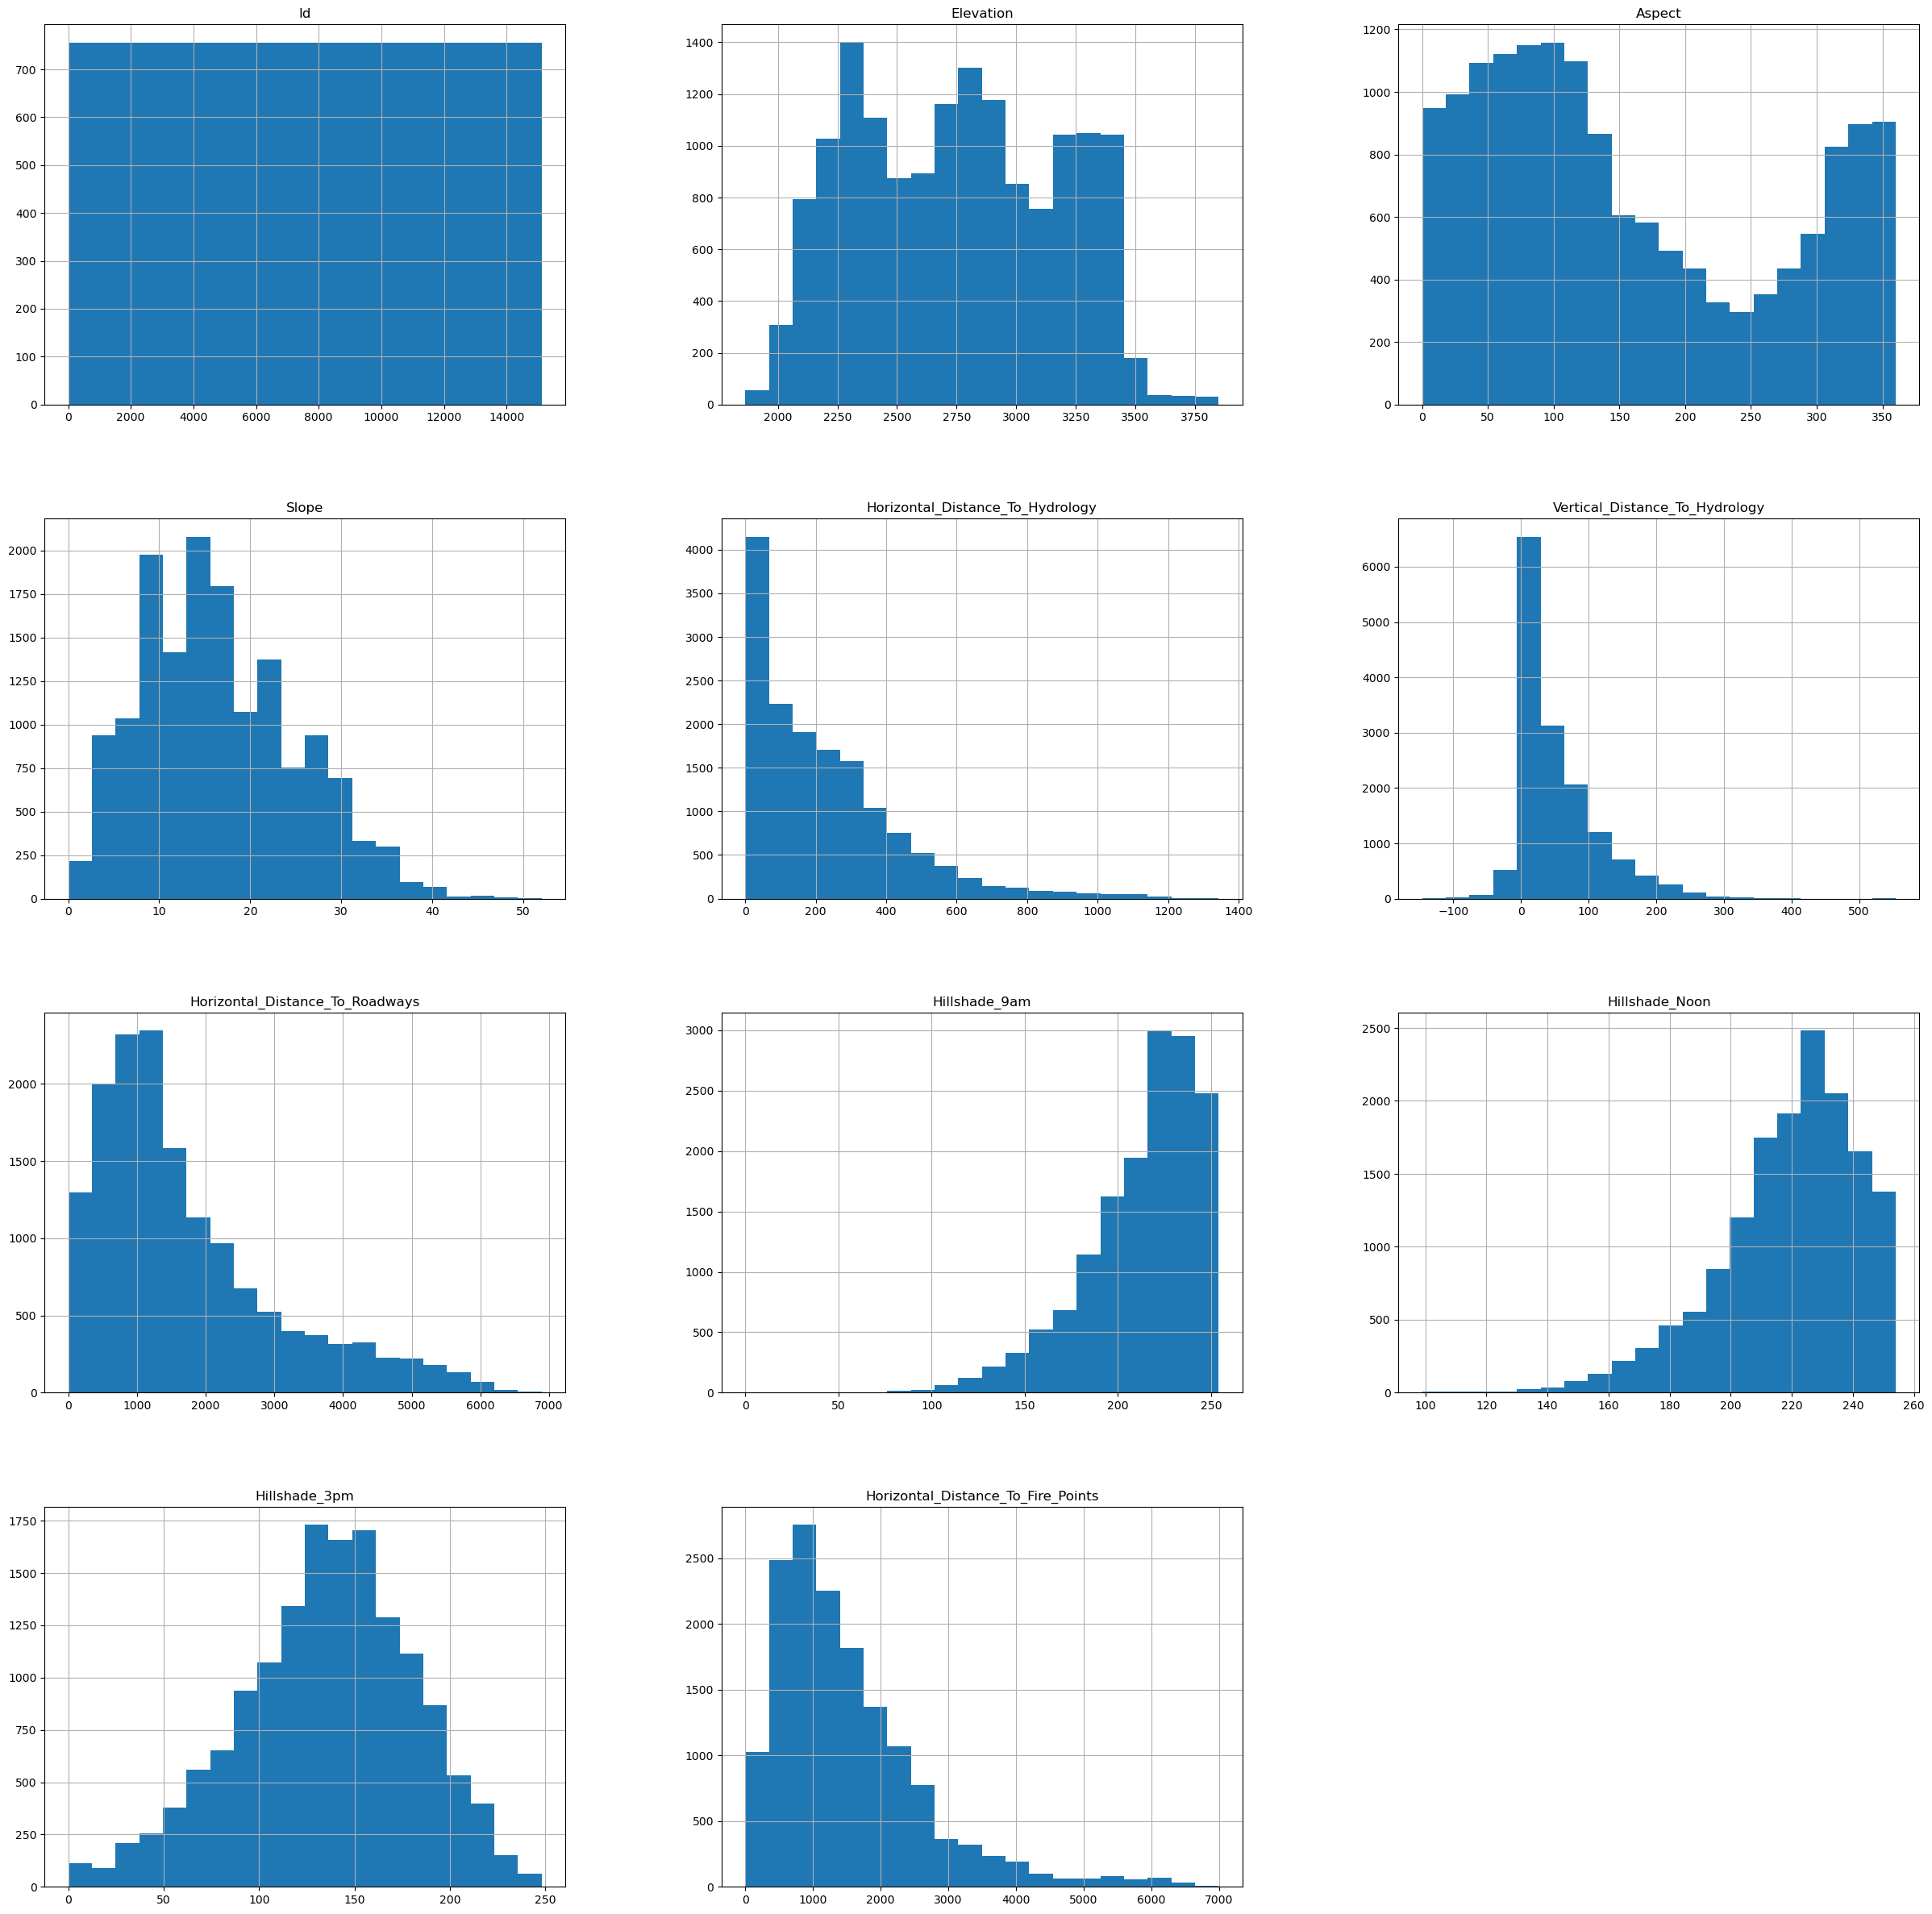

In [13]:
df.iloc[:,:11].hist(bins=20, figsize=(30,30))
plt.show()

### 2.2 Wilderness Area Types

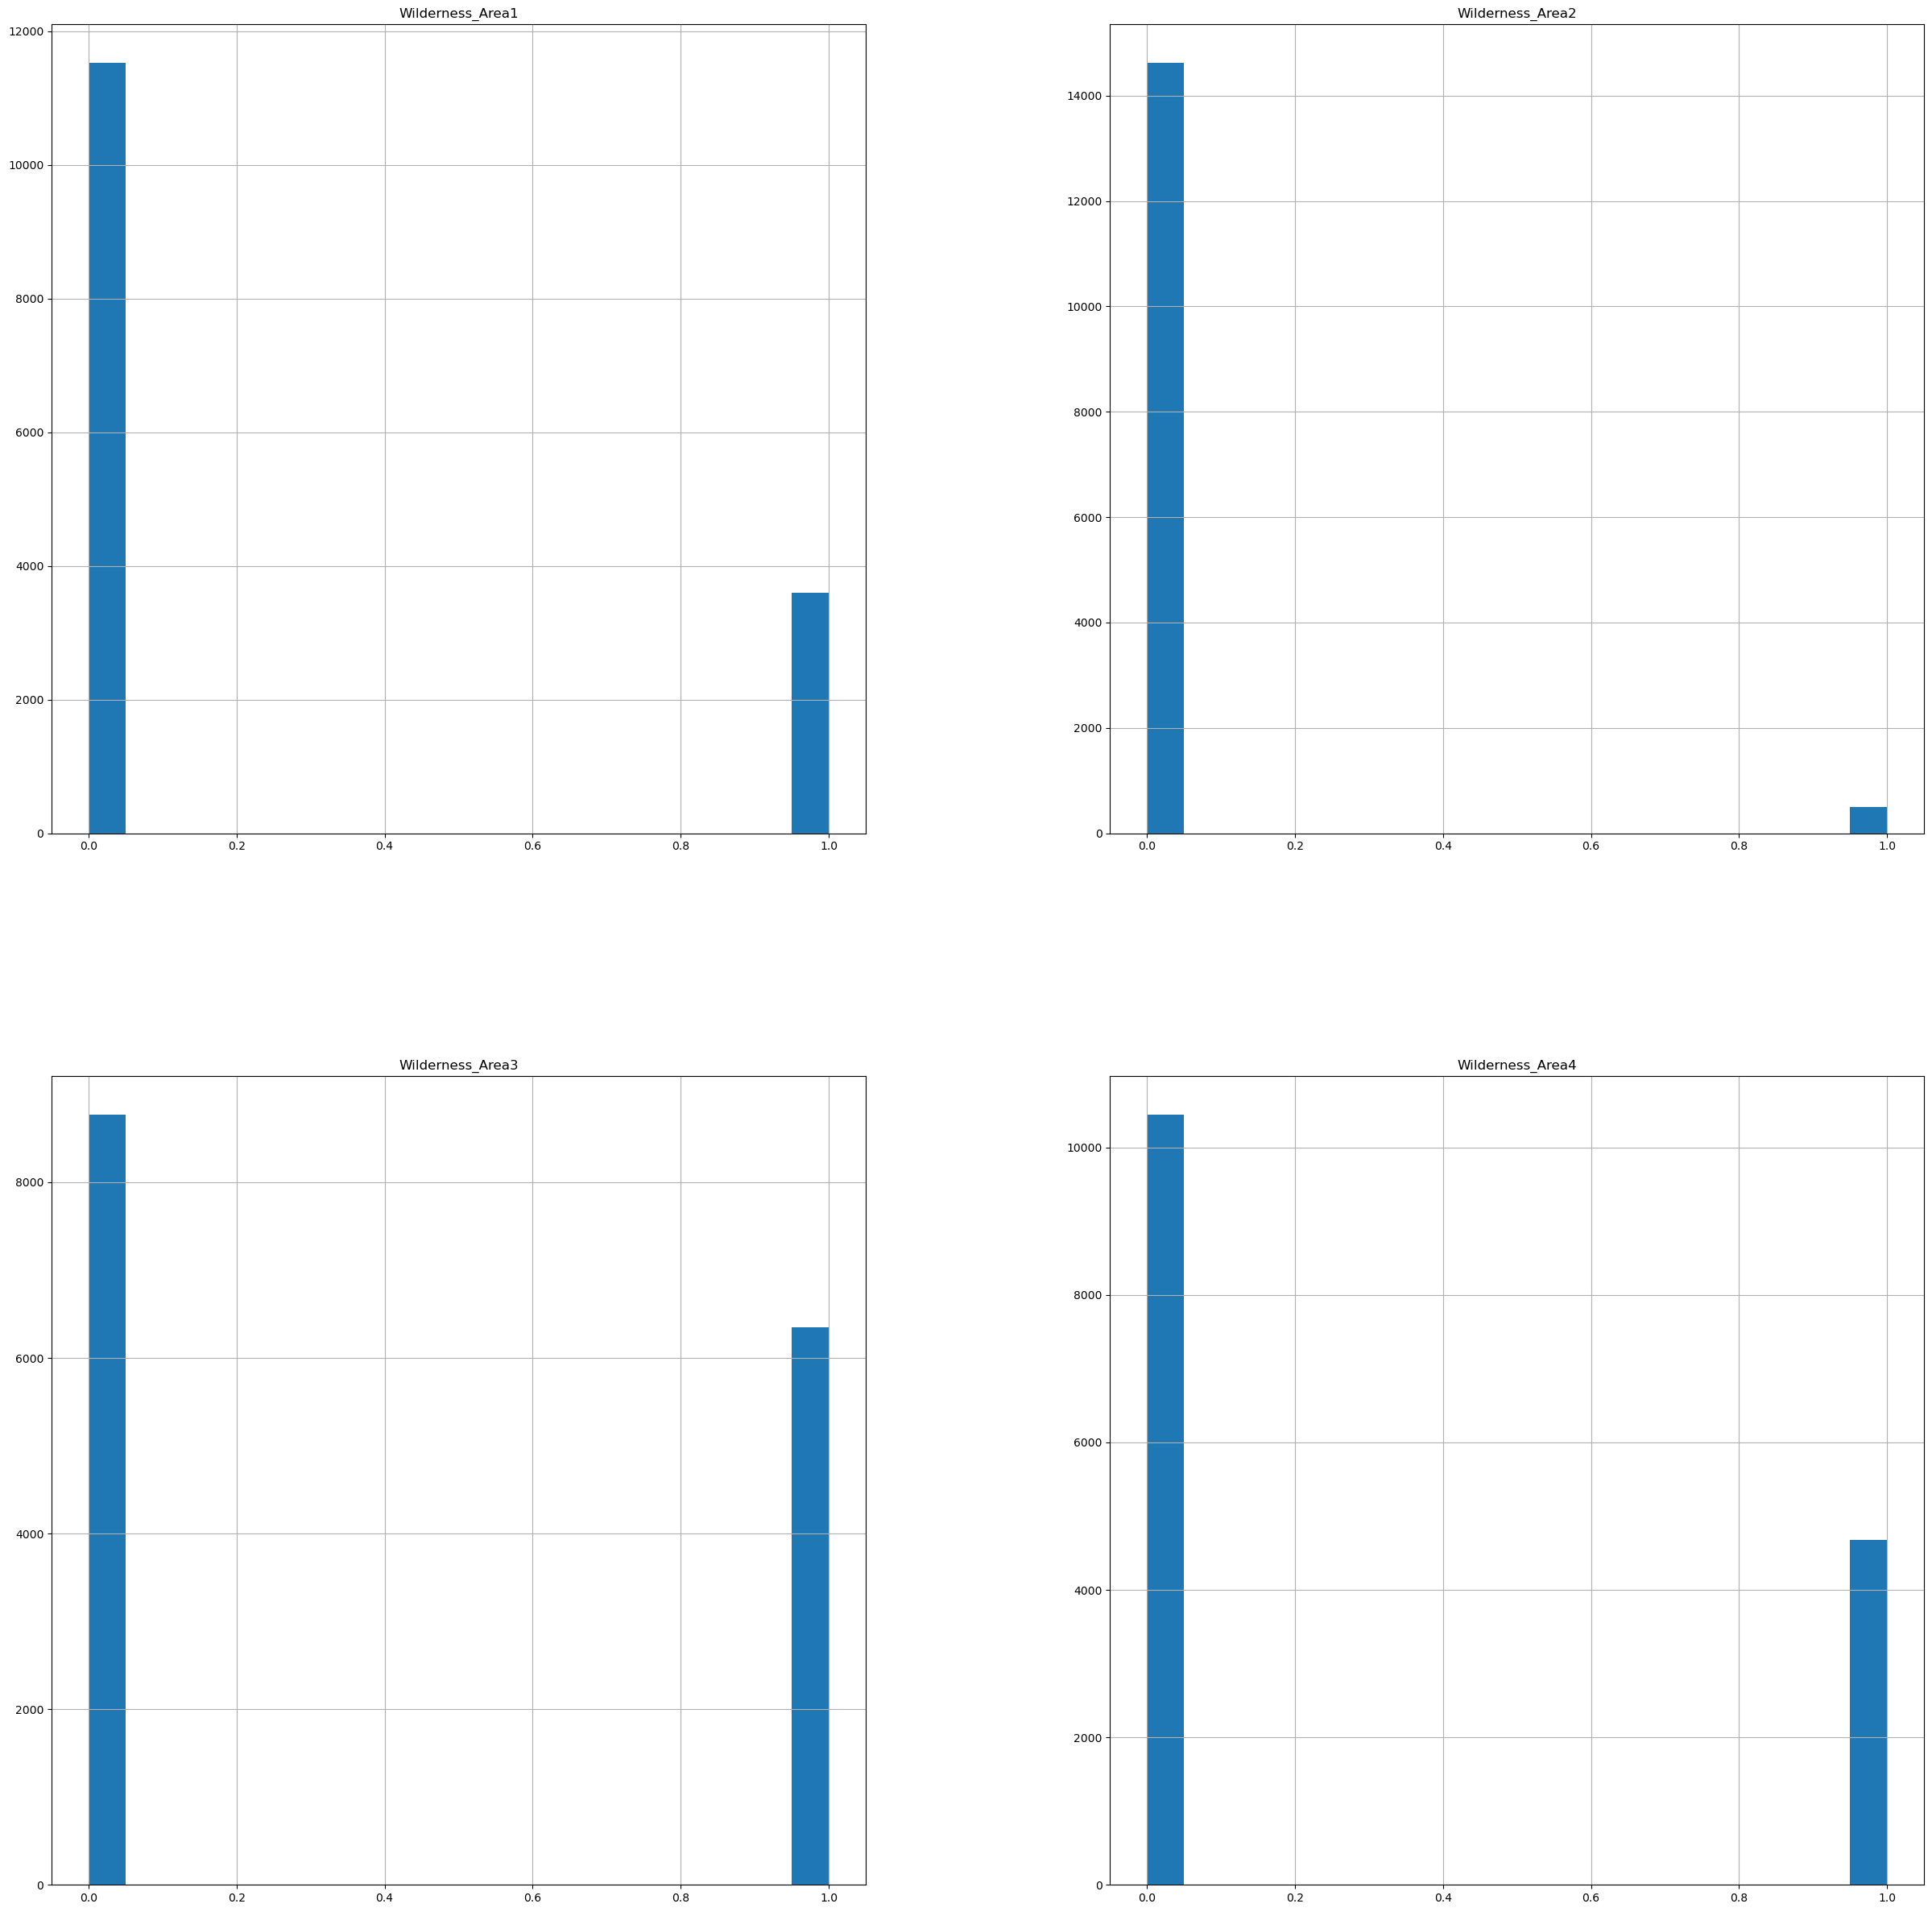

In [14]:
df.iloc[:,11:15].hist(bins=20, figsize=(30,30))
plt.show()

### 2.3 Soil Types and Target variables

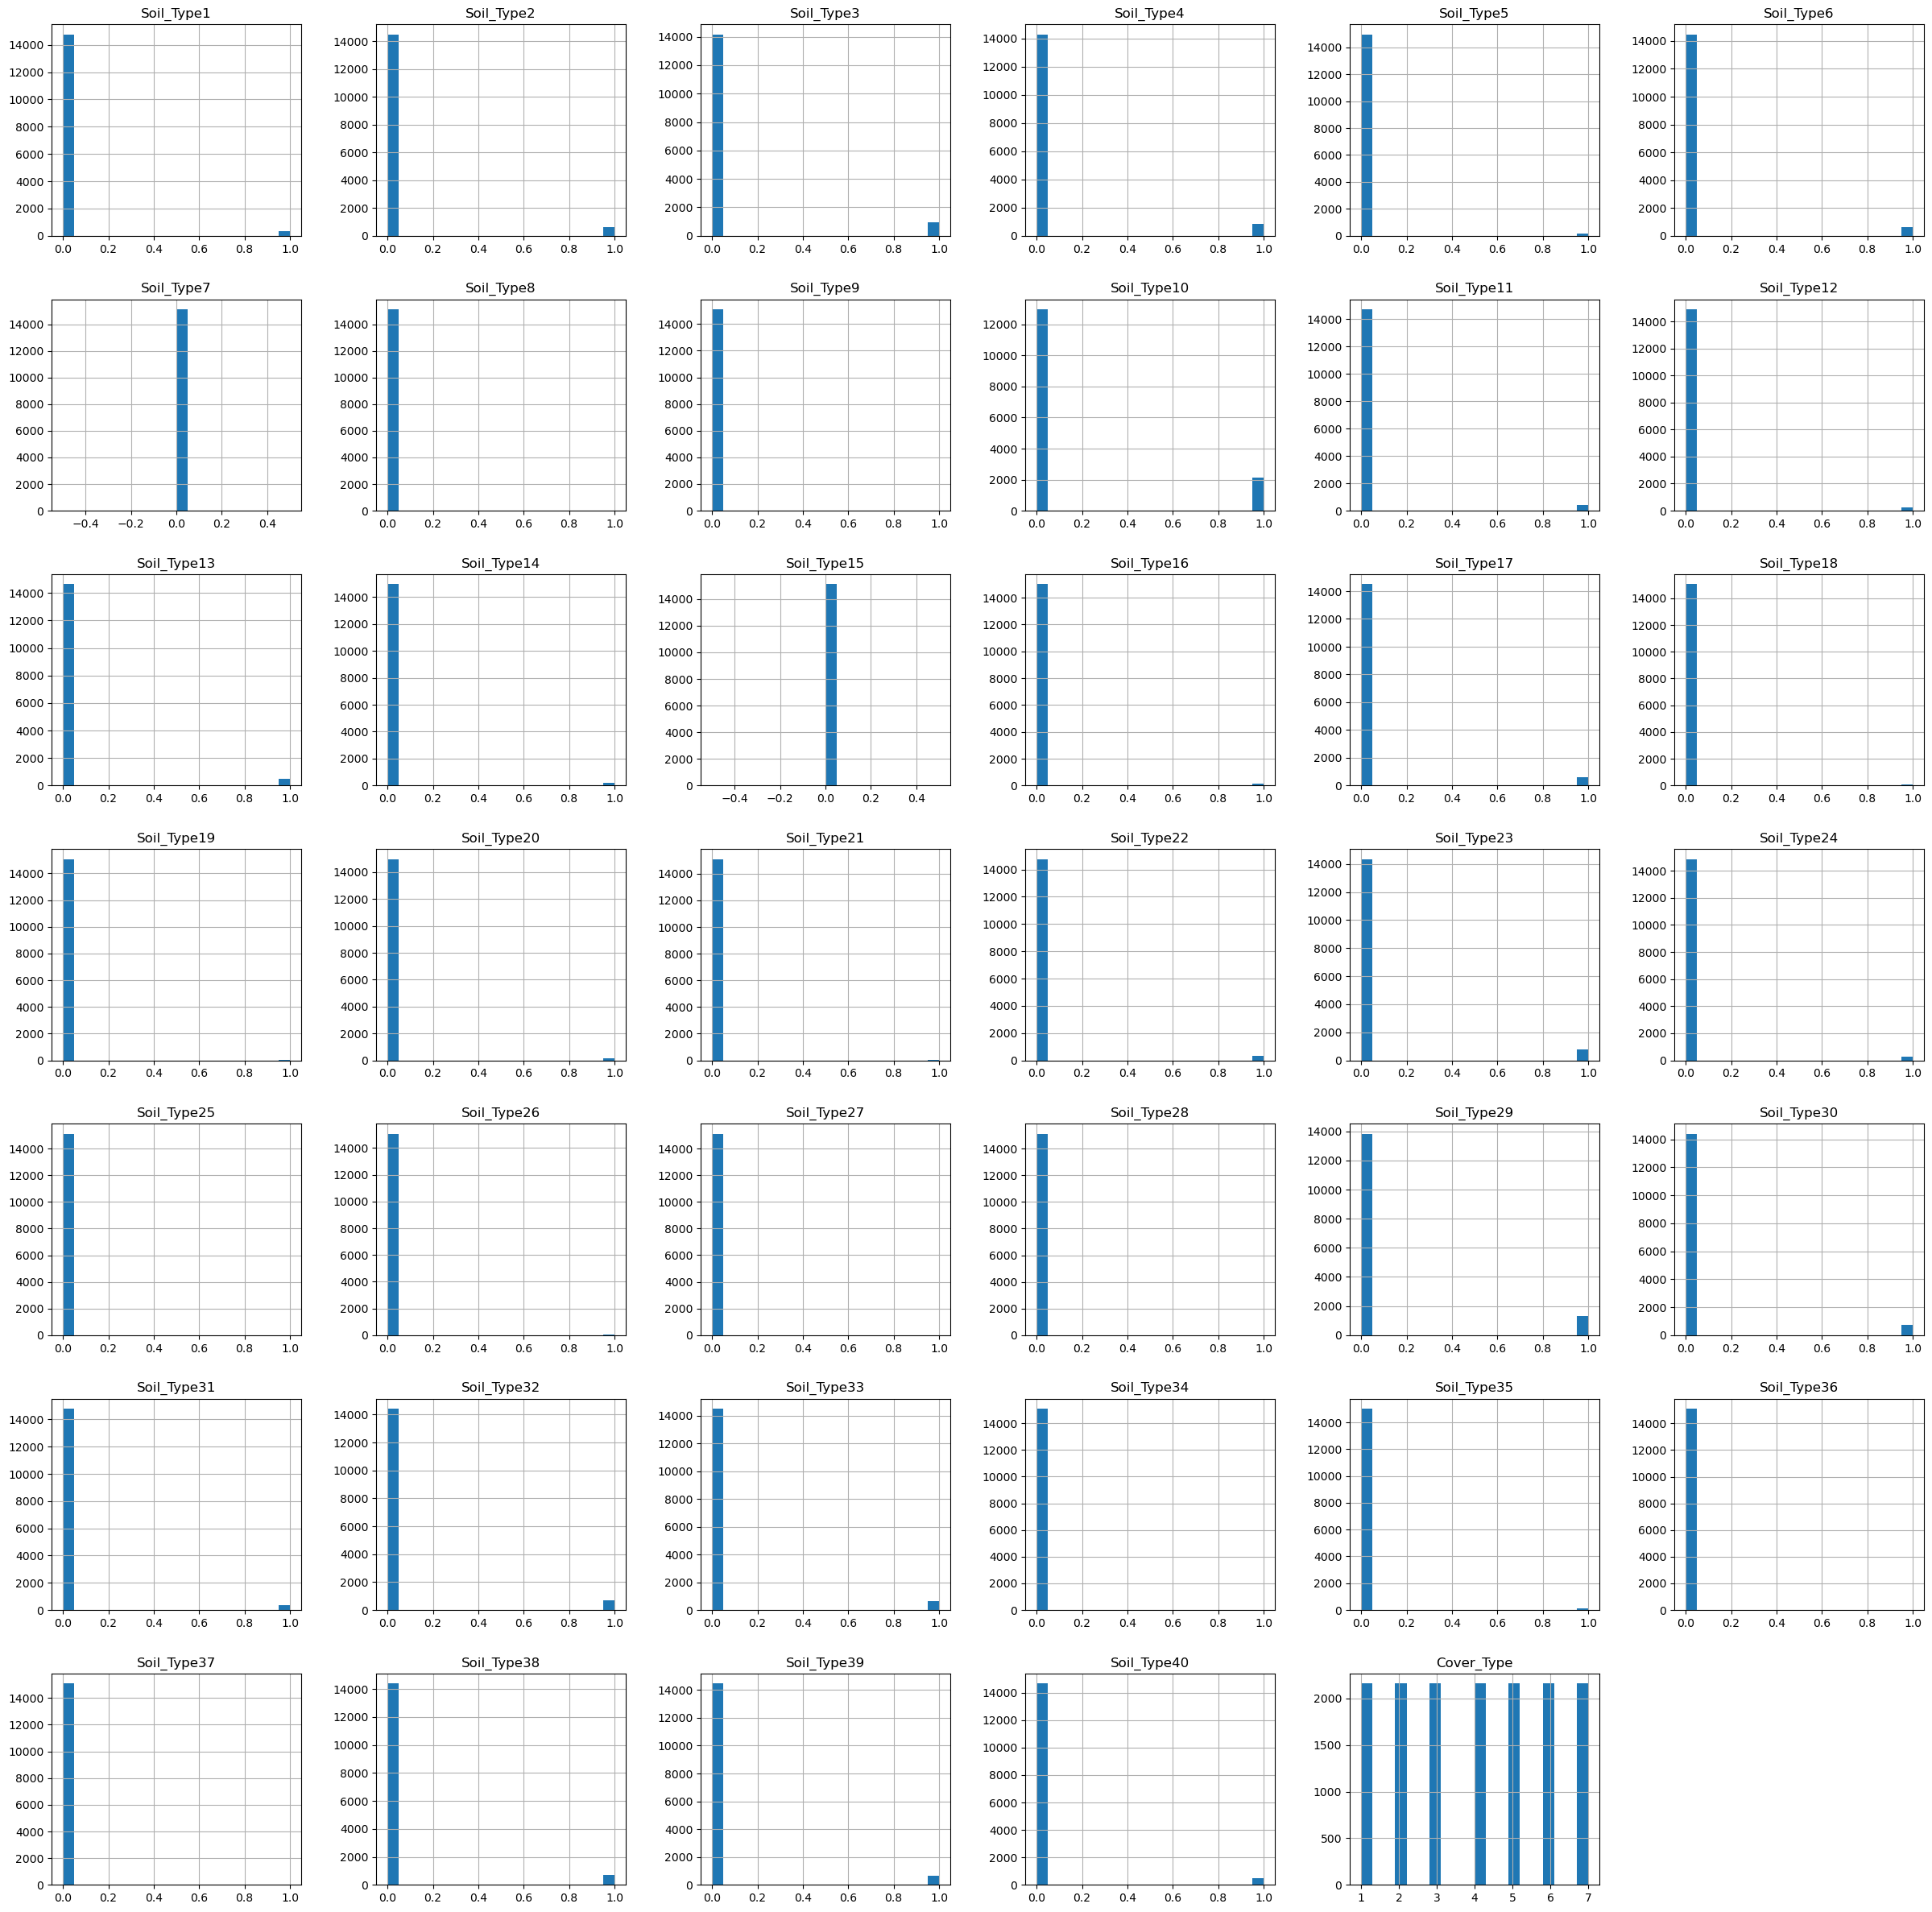

In [15]:
df.iloc[:,15:].hist(bins=20, figsize=(30,30))
plt.show()

## Can one Cover Type belong to multiple soil types and wilderness areas ?

In [16]:
# sum of all widerness area columns for train set
df["w_sum"] = df["Wilderness_Area1"] + df["Wilderness_Area2"] + df["Wilderness_Area3"] + df["Wilderness_Area4"]
print(df.w_sum.value_counts())

1    15120
Name: w_sum, dtype: int64


In [17]:
# sum of all widerness area columns for test file
test["w_sum"] = test["Wilderness_Area1"] + test["Wilderness_Area2"] + test["Wilderness_Area3"] + test["Wilderness_Area4"]
print(test.w_sum.value_counts())

1    565892
Name: w_sum, dtype: int64


In [18]:
# create a list of soil_type columns for train set
soil_columns = [c for c in df.columns if "Soil" in c]
df["soil_sum"] = 0

# sum of all soil type columns
for c in soil_columns:
    df["soil_sum"] += df[c]

print(df.soil_sum.value_counts())

1    15120
Name: soil_sum, dtype: int64


In [19]:
df.drop(columns=["w_sum", "soil_sum"], inplace=True)

In [20]:
# create a list of soil_type columns for test file
soil_columns = [c for c in test.columns if "Soil" in c]
test["soil_sum"] = 0

# sum of all soil type columns
for c in soil_columns:
    test["soil_sum"] += test[c]

print(test.soil_sum.value_counts())

1    565892
Name: soil_sum, dtype: int64


In [21]:
test.drop(columns=["w_sum", "soil_sum"], inplace=True)

In [22]:
df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

Wilderness_Area and Soil_Type1-40 having only binary values and only one soil_type or wilderness_area being equal to 1, shows that they are one-hot-encoded columns.

One important thing about cover type are, they can only belong to one soil type or one wilderness area.

Check if the Cover_Type shows non-uniform distribution among different Wilderness_Areas

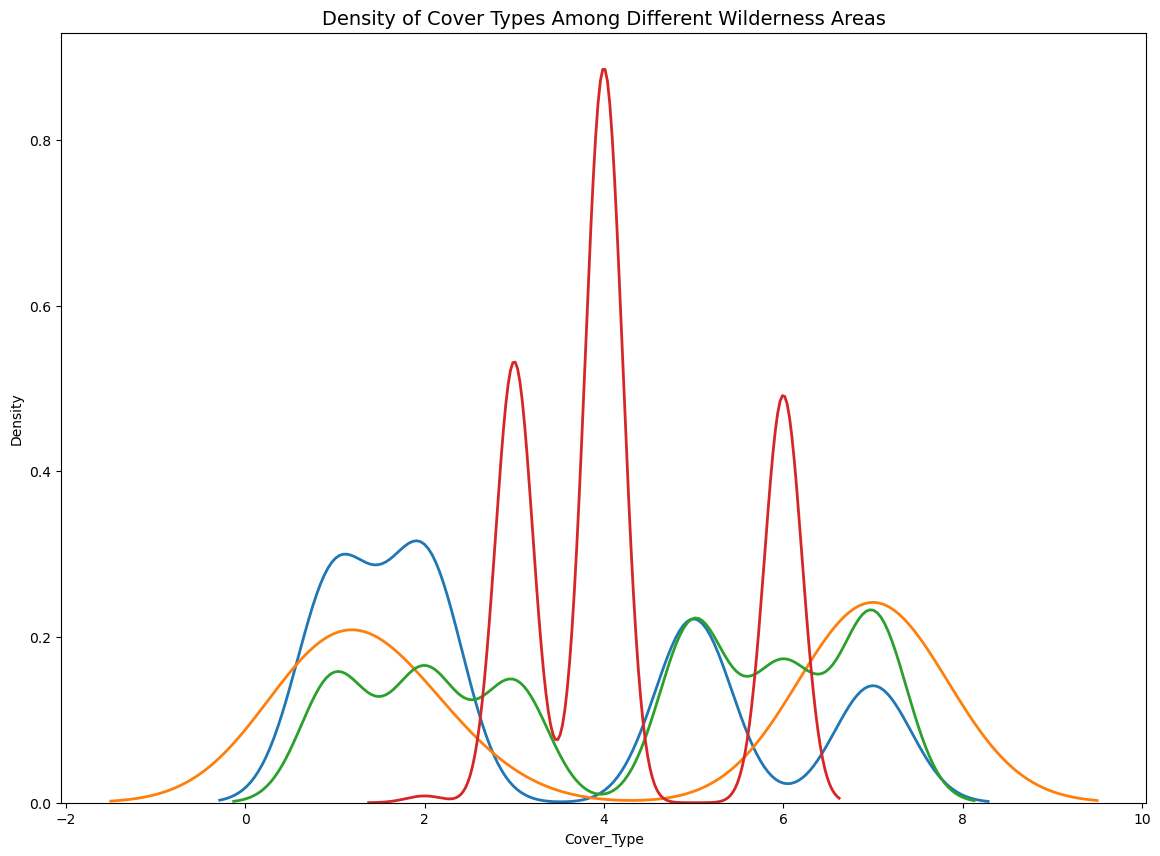

In [23]:
# Create one column as Wilderness_Area_Type and represent it as categorical data
df['Wilderness_Area_Type'] = (df.iloc[:, 11:15] == 1).idxmax(1)

#list of wilderness areas
wilderness_areas = sorted(df['Wilderness_Area_Type'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
plt.figure(figsize=(14,10))

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = df[df.Wilderness_Area_Type == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)
# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_Type")
plt.title("Density of Cover Types Among Different Wilderness Areas", size=14)

df.drop('Wilderness_Area_Type', axis=1, inplace=True)

In [19]:
df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

One of the other important finding: Wilderness area is an important feature to determine the cover type:

Spruce/Fir, Lodgepole Pine and Krummholz (Cover_Type 1, 2, 7) mostly found in Rawah, Neota and Comanche Peak Wilderness Area(1,2 and 3).
It is highly likely to find Ponderosa Pine (Cover_Type 3) in Cache la Poudre Wilderness Area (4) rather than other areas.
Cottonwood/Willow (Cover_Type 4) seems to be found only in Cache la Poudre Wilderness Area (4).
Aspen (Cover_Type 5) is equally likely to come from wilderness area Rawah and Comanche (1,3).
Douglas-fir (Cover_Type 6) can be found in any of the wilderness areas.
Note that, distribution of cover types extend more than the range because of the kernel density estimation.

Wilderness Area 3 is more diverse in soil type and cover type.
Only soil types 1 through 20 is represented in Wilderss Area 4, thus cover types in that area grew with them.
Cover type 7 seems to grow with soil types 25 through 40.
Cover Type 5 and 6 can grow with most of the soil types.
Cover Type 3 loves soil type 0 through 15.
Cover Type 1 and 2 can grow with any soil type.

### Visualize some collinear features with Cover_Type

Text(0.5, 1.0, 'Elevation VS Slope')

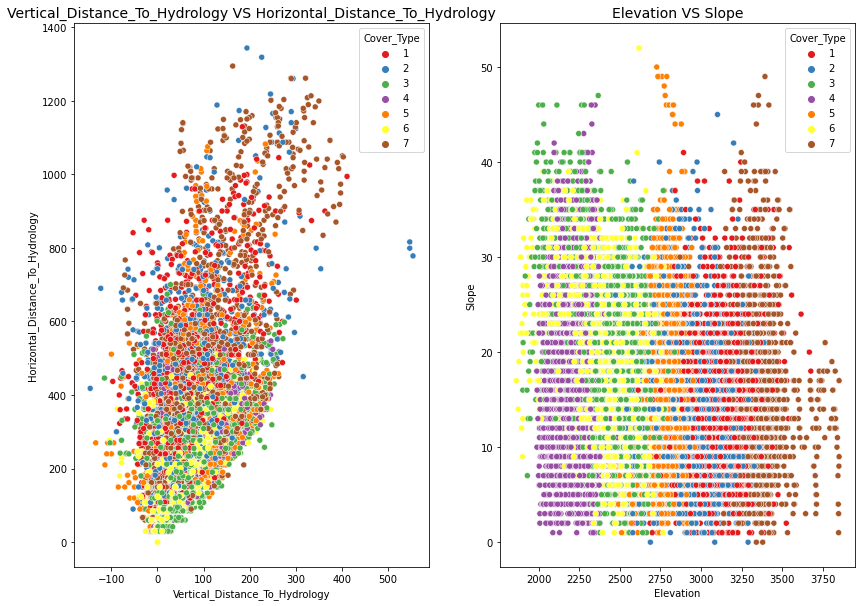

In [20]:
plt.figure(figsize=(14,10))

# plot the first subplot
plt.subplot(1,2,1)
sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology", 
                hue="Cover_Type", data=df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Vertical_Distance_To_Hydrology VS Horizontal_Distance_To_Hydrology", size=14)

# plot the second subplot
plt.subplot(1,2,2)
sns.scatterplot(x="Elevation", y="Slope", 
                hue="Cover_Type", data=df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Elevation VS Slope", size=14)

Text(0.5, 1.0, 'Hillshade_9am VS Hillshade_3pm')

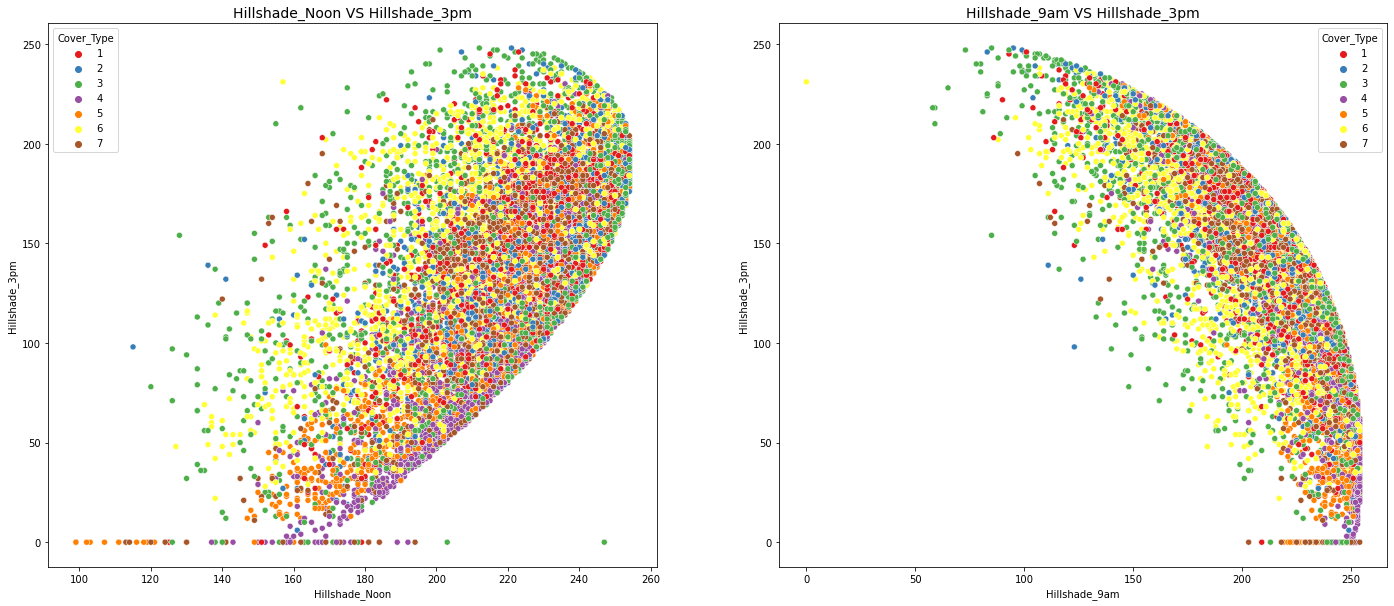

In [21]:
plt.figure(figsize=(24,10))

# plot the first subplot
plt.subplot(1,2,1)
sns.scatterplot(x="Hillshade_Noon", y="Hillshade_3pm", 
                hue="Cover_Type", data=df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Hillshade_Noon VS Hillshade_3pm", size=14)

# plot the second subplot
plt.subplot(1,2,2)
sns.scatterplot(x="Hillshade_9am", y="Hillshade_3pm", 
                hue="Cover_Type", data=df, 
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Hillshade_9am VS Hillshade_3pm", size=14)

One of the features from the Hillshade_9am or Hillshade_3pm or Hillshade_Noon will be dropped when determining the training set. for that we can use be determined after looking at the Pearson Coeffiecients with the label.

### Pearson Coefficients of all features

Text(0.5, 1.05, 'Pearson Correlation of All Features')

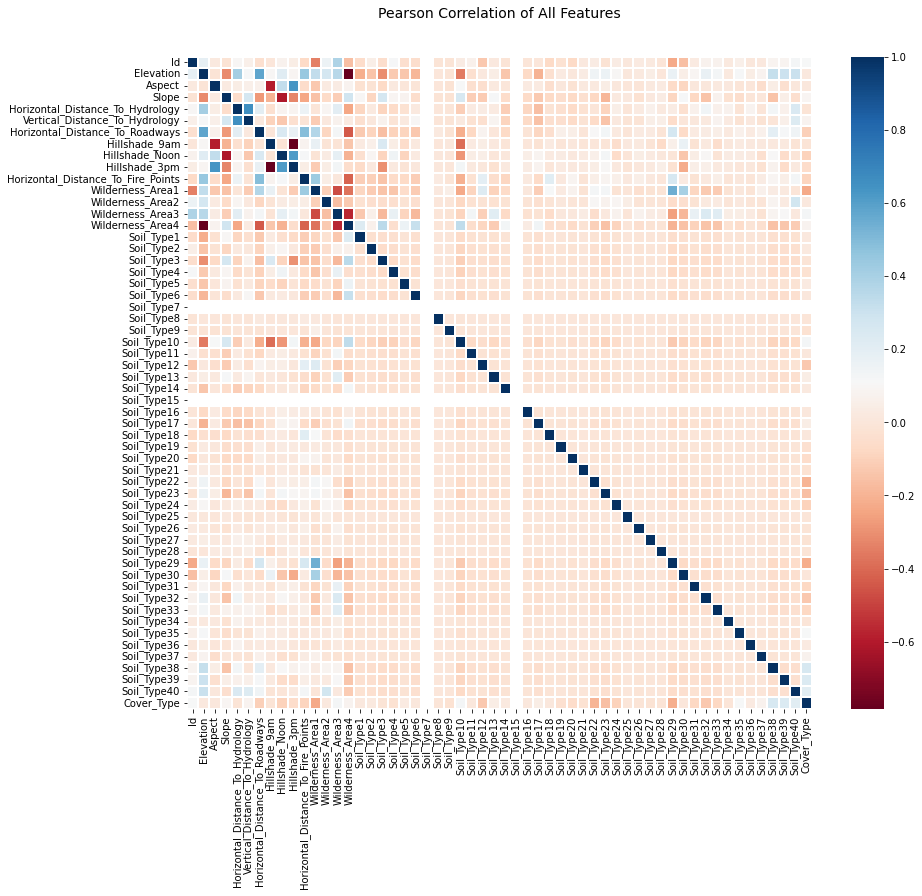

In [22]:
plt.figure(figsize=(14,12))

# plot heatmap set the title
colormap = plt.cm.RdBu
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap=colormap, linecolor='white', annot=False)
plt.title('Pearson Correlation of All Features', y=1.05, size=14)

Distributions:

Hillshade_9am and Hillshade_Noon has bi-modal and left-skewed distributions.
Horizontal_Distance_To_Firepoints, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Hydrology has bi-modal and right-skewed distributions.
Elevation resembles a uniform distribution.
Slope, Vertical_Distance_To_Hydrology, Hillshade_3pm shows a symmetric and bi-modal distribution.
Some obvious relationships between the continuous features:

Elevation and shows positive trend with following variables:
Vertical_Distance_To_Hydrology
Horizontal_Distance_To_Roadways
Horizontal_Distance_To_Firepoints
Horizontal_Distance_To_Hydrology
As Aspect increases; Hillshade_Noon and Hillshade_3pm increases.
Slope has negative trend with:
Elevation
Horizontal_Distance_To_Roadways
Hillshade_9am, Hillshade_Noon and Hillshade_3pm
Horizontal_Distance_To_Firepoints
Horizontal_Distance_To_Hydrology has positive trend with:
Horizontal_Distance_To_Firepoints
Horizontal_Distance_To_Roadways
Vertical_Distance_To_Hydrology
Vertical_Distance_To_Hydrology - Slope and Vertical_Distance_To_Hydrology - Horizontal_Distance_To_Hydrology has obvious collinear relationship.
As Horizontal_Distance_To_Roadways increases, Horizontal_Distance_To_Firepoints increases and Slope decreases.
Hillshade_9am shows negative trend with Hillshade_3pm and Aspect, as Hillshade_9am increases Elevation increases.
Hillshade_Noon has positive trend with:
Elevation
Aspect
Horizontal_Distance_To_Roadways
Hillshade_3pm
Horizontal_Distance_To_Firepoints
Hillshade_3pm shows perfect negative relationship with Hillshade_9am and perfect positive relationship with Hillshade_Noon.

None of the features are significantly different effect on determining the label cover type.

One interesting finding though, Soil Type 7 and 15 columns are blank in the heatmap, thus zero effect on determining the label Cover_Type.

Approximately 5 (1 percent of all soil types) soil_type columns affects the cover type.

Can we get a better picture if we use soil_type as one numeric column rather than seperate one-hot-encoded columns?

## Feature Engineering

### Feature transformation

In [23]:

## Euclidean Distance Function
def split_numbers_chars(row):
    '''This function fetches the numerical characters at the end of a string
    and returns alphabetical character and numerical chaarcters respectively'''
    head = row.rstrip('0123456789')
    tail = row[len(head):]
    return head, tail

''' No need for reverse one hot encoding, this is only used for visualization 
def reverse_one_hot_encode(x):

    x['String_Column'] = (x.iloc[:,x.columns.get_loc('Soil_Type1'):x.columns.get_loc('Soil_Type40')+1] == 1).idxmax(1)
    x['Tuple_Column'] = x['String_Column'].apply(split_numbers_chars)
    x['Soil_Type'] = x['Tuple_Column'].apply(lambda x: x[1]).astype('int64')
    x.drop(columns=['String_Column','Tuple_Column'], inplace=True)
    x['Soil_Type']=x['Soil_Type'].astype('category')
    x = x.drop(x.iloc[:,x.columns.get_loc('Soil_Type1'):x.columns.get_loc('Soil_Type40')+1],axis = 1)
    return x;
'''
def Euc_distance(x):
    a = np.power(x['Horizontal_Distance_To_Hydrology'],2)
    b = np.power(x['Vertical_Distance_To_Hydrology'],2)
    x['Euclidean_Distance_To_Hydrology'] = np.sqrt(a + b)
    return x;
## Euclidean Distance Function
def Direction_Aspect(x):   
    x['Aspect'] =np.tan(x['Aspect'])
    return x;
### Obtaining avg distances for numerical variables(vertical)
def mean_vertical(x):
    a ='Vertical_Distance_To_Hydrology'
    b ='Elevation'
    x['avg_hydro_elev'] = (x[a]+x[b])/2
    return x;
### Obtaining avg distances for numerical variables (horizontal)
def mean_horizontal(x):
    a ='Horizontal_Distance_To_Hydrology'
    b ='Horizontal_Distance_To_Roadways'
    c='Horizontal_Distance_To_Fire_Points'
    x['avg_hydro_fire'] = (x[a]+x[c])/2
    x['avg_hydro_road'] = (x[a]+x[b])/2
    x['avg_road_fire'] = (x[b]+x[c])/2
    return x;

def root_transform(x):
    x['Horizontal_Distance_To_Hydrology_root']=np.sqrt(x['Horizontal_Distance_To_Hydrology'])
    x['Horizontal_Distance_To_Roadways_root']=np.sqrt(x['Horizontal_Distance_To_Roadways'])
    x['Horizontal_Distance_To_Fire_Points_root']=np.sqrt(x['Horizontal_Distance_To_Fire_Points'])
    x['Euclidean_Distance_To_Hydrology_root']=np.sqrt(x['Euclidean_Distance_To_Hydrology'])

    return x;

In [24]:
df = Euc_distance(df)
df = Direction_Aspect(df)
df = mean_vertical(df)
df = mean_horizontal(df)
df = root_transform(df)
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Euclidean_Distance_To_Hydrology,avg_hydro_elev,avg_hydro_fire,avg_hydro_road,avg_road_fire,Horizontal_Distance_To_Hydrology_root,Horizontal_Distance_To_Roadways_root,Horizontal_Distance_To_Fire_Points_root,Euclidean_Distance_To_Hydrology_root
0,1,2596,0.903086,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,258.000000,1298.0,3268.5,384.0,3394.5,16.062378,22.583180,79.240141,16.062378
1,2,2590,-0.611274,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,212.084889,1292.0,3218.5,301.0,3307.5,14.560220,19.748418,78.898669,14.563135
2,3,2804,0.969519,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,275.769832,1434.5,3194.5,1724.0,4650.5,16.370706,56.391489,78.236820,16.606319
3,4,2785,1.792654,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,269.235956,1451.5,3226.5,1666.0,4650.5,15.556349,55.587768,78.809898,16.408411
4,5,2595,1.619775,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,153.003268,1297.0,3162.5,272.0,3281.5,12.369317,19.773720,78.562077,12.369449


In [25]:
df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

### Dropping Features

In [26]:
### decided to drop Soil Type 7 and 15 since they have only one value, which is 0. A constant does not provide information to the model in this situation.

df.drop(['Soil_Type7','Soil_Type15'],axis=1,inplace=True)
test.drop(['Soil_Type7','Soil_Type15'],axis=1,inplace=True)

In [27]:
df.corrwith(df.Cover_Type).head(10)

Id                                  0.108363
Elevation                           0.016090
Aspect                              0.001439
Slope                               0.087722
Horizontal_Distance_To_Hydrology   -0.010515
Vertical_Distance_To_Hydrology      0.075647
Horizontal_Distance_To_Roadways    -0.105662
Hillshade_9am                      -0.010286
Hillshade_Noon                     -0.098905
Hillshade_3pm                      -0.053399
dtype: float64

In [28]:
### Hillshade 9, Noon and 3pm are highly correlated
### we dropp Hillshade 9 as it has the lowest correlation to the target variable out of the 3 variables

df.drop('Hillshade_9am',axis=1, inplace=True)
test.drop('Hillshade_9am',axis=1, inplace=True)

In [29]:
df.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type', 'Euclidean_Distance_To_

In [30]:
df.corrwith(df.Cover_Type)

Id                                         0.108363
Elevation                                  0.016090
Aspect                                     0.001439
Slope                                      0.087722
Horizontal_Distance_To_Hydrology          -0.010515
Vertical_Distance_To_Hydrology             0.075647
Horizontal_Distance_To_Roadways           -0.105662
Hillshade_Noon                            -0.098905
Hillshade_3pm                             -0.053399
Horizontal_Distance_To_Fire_Points        -0.089389
Wilderness_Area1                          -0.230117
Wilderness_Area2                           0.014994
Wilderness_Area3                           0.122146
Wilderness_Area4                           0.075774
Soil_Type1                                 0.015069
Soil_Type2                                 0.022627
Soil_Type3                                -0.016393
Soil_Type4                                -0.027816
Soil_Type5                                 0.027692
Soil_Type6  

## Building the Pipeline

## Extra trees classifier

In [31]:
##Score: 0.77238 


In [32]:
## Model After grid search
model = ExtraTreesClassifier(max_features=None, min_samples_leaf=2, min_samples_split=6,
                     n_estimators=900, random_state=2022)
#No need to run grid search again, but if you do want to run it, erase the ''' on top and bottom
# and comment the model variable on top with #
'''
from sklearn.model_selection import RandomizedSearchCV
grid = {'n_estimators': [600,700,800,900,1000,1100,1200,1300,1400,1500],
                       'min_samples_leaf': [1,2,3,4],
                       'min_samples_split': [5,6,7,8, 9, 10, 11, 12],
                       'max_features': ['auto', 'sqrt', 'log2', None]}
np.random.seed(42)

clf = ExtraTreesClassifier(random_state=2022)
model= RandomizedSearchCV(estimator=clf,
                          param_distributions=grid,
                          n_iter=20,scoring = 'accuracy',
                          cv=5,
                          verbose=2,random_state=2022)

'''

model_pipeline = Pipeline(steps=[('model', model)])


set_config(display='diagram')
display(model_pipeline)

Pipeline(steps=[('model',
                 ExtraTreesClassifier(max_features=None, min_samples_leaf=2,
                                      min_samples_split=6, n_estimators=900,
                                      random_state=2022))])

In [33]:
y = df['Cover_Type']
x = df.drop("Cover_Type",axis=1)
model.fit(x, y);

In [34]:
test = Euc_distance(test)
test = Direction_Aspect(test)
test = mean_vertical(test)
test = mean_horizontal(test)
test = root_transform(test)
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Euclidean_Distance_To_Hydrology,avg_hydro_elev,avg_hydro_fire,avg_hydro_road,avg_road_fire,Horizontal_Distance_To_Hydrology_root,Horizontal_Distance_To_Roadways_root,Horizontal_Distance_To_Fire_Points_root,Euclidean_Distance_To_Hydrology_root
0,15121,2680,-1.557304,14,0,0,2684,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1340.0,3322.5,1342.0,4664.5,0.0,51.807335,81.516869,0.0
1,15122,2683,0.000000,13,0,0,2654,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1341.5,3337.5,1327.0,4664.5,0.0,51.516987,81.700673,0.0
2,15123,2713,0.300632,15,0,0,2980,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1356.5,3172.0,1490.0,4662.0,0.0,54.589376,79.649231,0.0
3,15124,2709,-2.134897,17,0,0,2950,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1354.5,3187.0,1475.0,4662.0,0.0,54.313902,79.837335,0.0
4,15125,2706,0.887143,19,0,0,2920,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1353.0,3202.0,1460.0,4662.0,0.0,54.037024,80.024996,0.0


In [35]:
y_preds=pd.Series(model.predict(test))
y_preds.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [36]:
model_1_pred= pd.Series(y_preds)
test_id=pd.Series(test.Id)
result = pd.DataFrame({'Id':test_id, 'Cover_Type':model_1_pred})
result.set_index('Id', inplace = True)
result.to_csv('prediction_extratrees.csv')#,sep=',', float_format='%.0f')